<a href="https://colab.research.google.com/github/lejimmy/handson-ml-workbooks/blob/master/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Look at the Big Picture
Welcome to Machine Learning Housing Corporation! The first task you are asked to perform is to build a model of housing prices in California using the California census data. This data has metrics such as the population, median income, median housing price, and so on for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them “districts” for short. Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.




## Frame the Problem

1. What is the business objective?

Your model's output (a prediction of a district's median housing price) will be fed to another Machine Learning system, along with many other signals.  The downstream system will determine whether it is worth investing in a given area or not.  Getting this right is critical, as it directly affects revenue.

2. What does the current solution look like?

District housing prices are currently estimated manually by experts: a team gathers up-to-date information about a district, and when they cannot get the median housing price, they estimate it using complex rules.

The current solution is costly and time-consuming, and their estimates are not great.

Their median housing price is often off by more than 10%.

3. How will you frame the problem?

It seems to be a good candidate for a regression algorithm.  Census data only comes out once every 10 years so batch learning is probably the best.

## Select a Performance Measure

For regression problems, a typical performance measure is the Root Mean Square Error (RMSE).

$RMSE(X,h) = \sqrt{\frac{1}{m} \sum_{i=1}^{m}(h(x^{i}) - y^{i})^2}$

In some contexts, the Mean Absolute Error (Average Absolute Deviation) may be considered.

$MAE(X, h) = \frac{1}{m}\sum_{i=1}^{m} \left| h(x^{i} - y^{i} \right|$

## Check the Assumptions

How will the downstream Machine Learning system use the median housing price?  If they are going to convert the prices into categories, then getting the price perfectly right is not important.  The problem should be framed a classification task instead of a regression task.

For this example, the downstream system will actually need the actual prices and not just categories.

# Get the Data

In [0]:
import os
import tarfile
from six.moves import urllib

# url to download the dataset
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"

# local path for housing data
HOUSING_PATH = os.path.join("datasets", "housing")

# location of dataset
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# function to download and extract housing data.
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
  
  # if folder does not exist, make folder
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
    
  # define where to download zip file
  tgz_path = os.path.join(housing_path, "housing.tgz")
  
  # download zip file
  urllib.request.urlretrieve(housing_url, tgz_path)
  
  # extract zip file
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path = housing_path)
  housing_tgz.close()

# call function
fetch_housing_data()

In [0]:
import pandas as pd

# function to read in csv to a DataFrame
def load_housing_data(housing_path = HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

# Take a Quick Look at the Data Structure

In [0]:
# call function and preview the DataFrame
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district.  There are 10 attributes.

In [0]:
# summarize DataFrame features
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


`total_bedrooms` appears to be missing 207 values.  All features are of type float 64 except for `ocean_proximity` which is an object.  Since this data came from a CSV, it is most likely a string.  Looking at the first 5 rows, `ocean_proximity` is most likely a categorical feature.

In [0]:
# count unique values of a DataFrame column (Series)
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

To quickly get an intuition of the data, we can use the describe function to view a statistical summary of the data.

In [0]:
# summary of numerical features
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


For numerical data, plotting a histogram can also help to get a feel for the data.

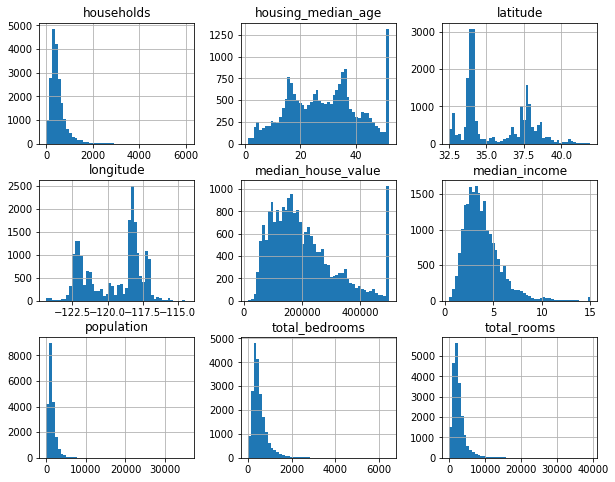

In [0]:
# plot histogram of numerical features
import matplotlib.pyplot as plt

%matplotlib inline

housing.hist(bins = 50, figsize = [10, 8])
plt.show()

Observations:
1. Median income is not expressed in US dollars.
2. Housing median age and median house value were capped.
- Since house values are the primary interest, we may have to collect more data or remove the districts from our training set.
3. All attributes have very different scales.
- Consider feature scaling
4. The histograms are tail heavy.
- Consider transforming these attributes to have a more bell-shaped distribution.

# Create a Test Set

In [0]:
import numpy as np

# split data in test and training sets
def split_train_test(data, test_ratio):
  
  # shuffle all indices
  shuffled_indices = np.random.permutation(len(data))
  
  # determine size of test set
  test_set_size = int(len(data) * test_ratio)
  
  # set aside the first portion for testing data
  test_indices = shuffled_indices[:test_set_size]
  
  # set aside the last portion for training data
  train_indices = shuffled_indices[test_set_size:]
  
  # return the DataFrame split into two data sets
  return data.iloc[train_indices], data.iloc[test_indices]

# call function to split with an 80/20 ratio
train_set, test_set = split_train_test(housing, 0.2)

# print the lenghts of each set
print("{} train + {} test".format(len(train_set), len(test_set)))

16512 train + 4128 test


With the current implementation, if you run the program multiple times, the model will see the entire dataset.

Though you save the test set or set a random seed, this will break for new datasets.

A better solution would be to use the hash of the instance's indentifer code.

In [0]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
  
  # hash each instance's identifier, return true if less than test ratio
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
  
  # list of ids
  ids = data[id_column]
  
  # returns True or False if id is in test set
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  
  # returns training set and testing set
  return data.loc[~in_test_set], data.loc[in_test_set]

Options for adding an identifier column:

In [0]:
# add an index column
housing_with_id = housing.reset_index()

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [0]:
# generate id based on latitude and longitude
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

Scikit-Learn provides built in `train_test_split` functions with additional features, such as: `random_state` parameter to set a seed, ability to pass multiple datasets with the same number of rows and indices. 

In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

In [0]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


## Stratified Sampling

So far our sampling method has been purely random.  

 However, to remove the chances of sampling bias, *stratified samping* will be used.  The population is divided into homogenous subgroups called *strata*.

 Suppose we chatted with experts  who said the median income is an important attribute to predict median housing prices. 
 
 We want to ensure the test set is representative of the various categories of incomes in the whole dataset. 
 
 For a continuous numerical attribute, we will create an income category attribute. 

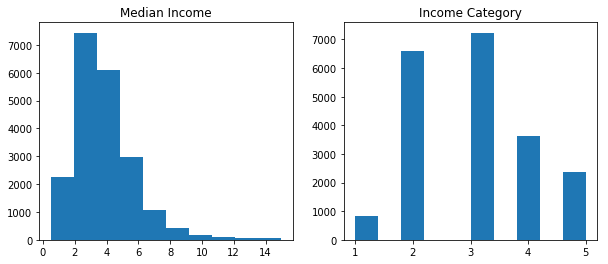

In [0]:
# create income categories from median household income
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins = [0., 1.5, 3.0, 4.5, 6., np.inf], 
                               labels = [1, 2, 3, 4, 5])

# plot before and after
plt.figure(figsize = [10,4])

# plot median income
plt.subplot(1,2,1)
plt.hist(data = housing, x = 'median_income')
plt.title('Median Income')

# plot income category
plt.subplot(1,2,2)
plt.hist(data = housing, x = 'income_cat')
plt.title('Income Category');

In [0]:
# use Scikit-Learn's StratifiedShuffleSplit class
from sklearn.model_selection import StratifiedShuffleSplit

# split the data once with a test size of 20%
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

# split the housing DataFrame by the Income Category series
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

The test set generated using stratified sampling has income category proportions that are nearly identical to those in the full dataset.

In [0]:
# drop income_cat
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat', axis = 1, inplace = True)

# Discover and Visualize the Data to Gain Insights

In [0]:
# create a copy of the training set

housing = strat_train_set.copy()

## Visualizing Geographical Data

Since there is geographical data, let's create a scatterplot of all districts to visualize the data

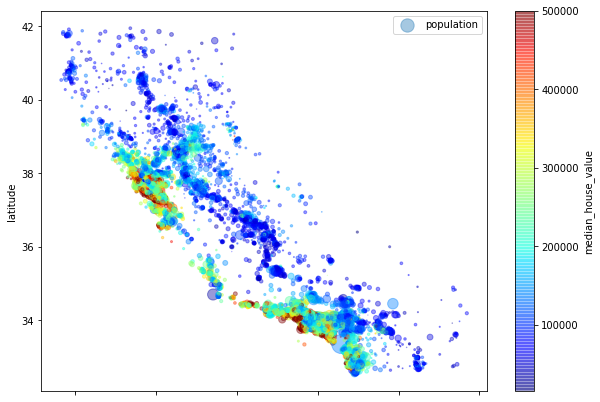

In [0]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4, 
             s = housing['population']/100, label = 'population', 
             c = 'median_house_value', cmap = plt.get_cmap('jet'), 
             colorbar = True, figsize = [10, 7])

plt.legend();

The image depicts that housing prices are related to the location and population density.

## Looking for Correlations

Let's computer the standard correlation coefficient or Pearson's r for every pair of attributes.

In [0]:
corr_matrix = housing.corr()

In [0]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

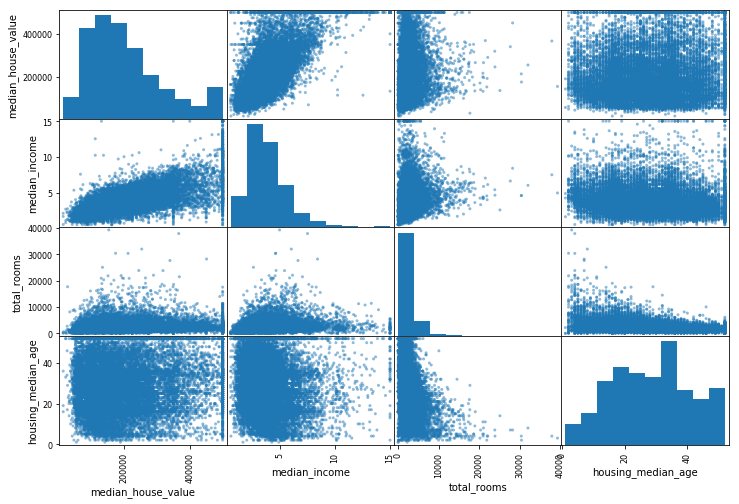

In [0]:
from pandas.plotting import scatter_matrix

# top 4 housing attributes
attributes = ['median_house_value', 'median_income', 'total_rooms', 
              'housing_median_age']

# matrix scatter plots
scatter_matrix(housing[attributes], figsize = [12, 8]);

The most promising attribute is the median income, let's take a closer look.

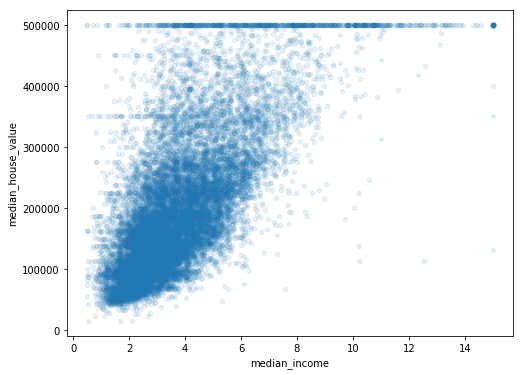

In [0]:
housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1, figsize = [8, 6]);

This plot reveals that there is a clear correlation between median income and median house value.

There are also some interesting pricing cap lines at: \$500k, \$450k, \$350k,  and some others below this number.

Possible additional exploration tasks:
- remove districts that fall on the horizontal lines
- transform tail heavy distributions
- trying out various attribute combinations

## Experimenting with Attribute Combinations

In [0]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [0]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The new `bedrooms_per_room` attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

# Prepare the Data for Machine Learning Algorithms



First, let's revert to a clean training set and separate the predictors and the labels.

In [0]:
# copy training set without the median house values
housing = strat_train_set.drop('median_house_value', axis = 1)

# copy the median house values into a separate Series
housing_labels = strat_train_set['median_house_value'].copy()

## Data Cleaning

Since most Machine Learning algorithms cannot work with missing features, let's take care of the missing values in `total_bedrooms`.

We can either drop the districts, drop the whole attribute, or fill in the missing values (zero, mean, median, etc.)

In [0]:
# option 1: dropping the missing rows
# housing.dropna(subset = ['total_bedrooms'])

# option 2: dropping the entire attribute
# housing.drop('total_bedrooms', axis = 1)

# option 3: computing the median and filling the missing values
# median = housing['total_bedrooms'].median()
# housing['total_bedrooms'].fillna(median, inplace = True)

In [0]:
from sklearn.impute import SimpleImputer

# create a SimpleImputer instance and specify to replace 
# each missing value with the median
imputer = SimpleImputer(strategy = 'median')

# create copy of data without categorical attributes
housing_num = housing.drop('ocean_proximity', axis = 1)

# fit/train the imputer
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

It is safter to apply the imputer on all numerical attributes to catch missing values in the future.

In [0]:
# numpy array of median of each attribute
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [0]:
# confirm the median values are the same
housing_num.median()

longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64

In [0]:
# use imputer to replace missing values by the learned medians
X = imputer.transform(housing_num)

In [0]:
# turn NumPy array back into a DataFrame
housing_tr = pd.DataFrame(X, columns = housing_num.columns,
                          index = housing_num.index)

In [0]:
# confirm there are no missing values 
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.1 MB


## Handling Text and Categorical Attributes

Since most Machine Learning algorithms prefer to work with numbers, let's convert these categories from text to numbers.

We can use Scikit-Learn's OrdinalEncoder class.

In [0]:
from sklearn.preprocessing import OrdinalEncoder

# create DataFrame of only the ocean_proximity attribute
housing_cat = housing[['ocean_proximity']]

# constructer
ordinal_encoder = OrdinalEncoder()

# transformer
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

# preview first 10 rows
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [0]:
# view categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

To avoid ML algorithms from assuming two nearby values are more similar than two distant values, we will use *one-hot encoding* to create *dummy* attributes.

In [0]:
from sklearn.preprocessing import OneHotEncoder

# constructer
cat_encoder = OneHotEncoder()

# transformer
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Since *one-hot encoding* creates many 0 values, a *sparse matrix* is used to only store the location of the non zero values.

In [0]:
# view categories
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need is to create a class and implement three methods: fit() (returning self), transform(), and fit_transform(). You can get the last one for free by simply adding TransformerMixin as a base class. Also, if you add BaseEstimator as a base class (and avoid \*args and \**kargs in your constructor) you will get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning. For example, here is a small transformer class that adds the combined attributes we discussed earlier:

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Feature Scaling

Since ML algorithms don't perform well when numerical input attributes have very different scales, we will have to apply *feature scaling*.

To get all attributes to have the same scale, we can use: *min-max scaling* or *standardization*.

Min-max scaling (or normalization) shifts numerical values and rescales so they all range from 0 to 1.  This is achieved by subtracting the min value and dividing by the max minus the min.  We can use Scikit-Learn's  `MinMaxScaler` transformer for this.

Standardization subtracts the mean value then divides it by the standard deviation.  Standardization is less affected by outliers but does not bound values to a specific range, which may be a problem for some algorithms that expect an input between 0 and 1.

## Transformation Pipelines

Since many data transformation steps need to be executed in the right order, Scikit-Learn provides the `Pipeline` class to help with sequences of transformations.

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# create a transformation pipeline
num_pipeline = Pipeline([
          # fills in missing values with the median
          ('imputer', SimpleImputer(strategy = 'median')),
          # adds custom attribute combinations
          ('attribs_adder', CombinedAttributesAdder()),
          # standardization feature scaling
          ('std_scaler', StandardScaler()),
    ])

# fit and transform in order of the pipeline
housing_num_tr = num_pipeline.fit_transform(housing_num)

Previously, we've handled categorical columns and numerical columns separately.  Let's build a single transformer to handle all columns.  We will use Scikit-Learn's `ColumnTransformer` for this purpose.

In [0]:
from sklearn.compose import ColumnTransformer

# list of numerical columns
num_attribs = list(housing_num)
# list of categorical columns
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
          # calls previous numerical transformation pipeline
          ('num', num_pipeline, num_attribs),
          # calls OneHotEncoder() for categorical attributes
          ('cat', OneHotEncoder(), cat_attribs),
])

# fit and transform both numerical and categorical attributes
housing_prepared = full_pipeline.fit_transform(housing)

In [0]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Select and Train a Model

So far we have:
1. Framed the problem
2. Gathered the data
3. Explored the data
4. Sampled a training and test set
5. Wrote a transformation pipeline to prepare for ML algorithms

Now we are ready to select and train a ML model.

## Training and Evaluating on the Training Set

In [0]:
from sklearn.linear_model import LinearRegression

# LinearRegression constructor
lin_reg = LinearRegression()

# fit the prepared housing data, housing labels
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# view a few instances from the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

print('Predictions: ', lin_reg.predict(some_data_prepared))
print('Labels: ', list(some_labels))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Let's measure the regression model's RMSE on the whole training set using Scikit-Learn's `mean_squared_error` function.

In [0]:
from sklearn.metrics import mean_squared_error

# predict the values of the homes using the prepared features
housing_predictions = lin_reg.predict(housing_prepared)

# calculate error from labels and predictions
lin_mse = mean_squared_error(housing_labels, housing_predictions)

# take the square root
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Since the `median_housing_values` range between \$120-265k, an error of \$68k is not very satisfying.

The current model is underfitting the training data.  To improve a model that is underfitting we have the options to:
- Use a more powerful model
- Feed the training algorithm with better features
- Reduce the contraints

Let's switch to a more powerful model for our example.

In [0]:
from sklearn.tree import DecisionTreeRegressor

# DecisionTreeRegressor constructor
tree_reg = DecisionTreeRegressor()

# fit the prepared housing data, housing labels
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [0]:
# predict the values of the homes using the prepared features
housing_predictions = tree_reg.predict(housing_prepared)

# calculate error from labels and predictions
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The error 0!  Either our model is perfect, or the model has badly overfit the data.  Because we don't want to test the model on the tesing set until we are confident of our results, let's use part of the trainign set for training and part for model validation.

## Better Evaluation Using Cross-Validation

Though we could do another `train_test_split` to split our training set into a smaller training and validation set, a great alternative is to use Scikit-Learn's K-fold cross-validation feature.

This will split the training set into 10 subsets called folds, trains and evaluates the Decision Tree model 10 times.  The resulting array will contain the 10 evaluation scores.

In [0]:
from sklearn.model_selection import cross_val_score

# cross validate our Decision Tree with our prepared data and the labels
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring = 'neg_mean_squared_error', cv = 10)

tree_rmse_scores = np.sqrt(-scores)

Since the cross-validation feature expects a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (a negative value), therefore the last line computes the `-scores` before calculating the square root.

In [0]:
def display_scores(scores):
  print('Scores: ', scores)
  print('Mean: ', scores.mean())
  print('Standard Deviation: ', scores.std())
  
display_scores(tree_rmse_scores)

Scores:  [69962.58221078 66839.83880064 70412.39685715 70128.72727273
 70876.6708022  73521.6321153  70986.9911563  71647.10596907
 76758.3639049  69299.18325318]
Mean:  71043.34923422469
Standard Deviation:  2496.2585078565253


The Decision Tree has a score of approximately 71,407 +- 3,328.

Cross-validation shows the performance and precision (standard deviation) of the model's estimate.

It appears the Decision Tree did worst than the Linear Regression model.

To be sure, let's compute the same scores for the Linear Regression model.

In [0]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring = 'neg_mean_squared_error', cv = 10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard Deviation:  2731.674001798344


The Linear Regression model has a score of approximately 69,052 +- 2,731

This confirms that the Decision Tree is overfitting so badly it is performing worse than the Linear Regression model.

Finally, let's try the `RandomForestRegressor` model.  Random Forests work by training many Decision Trees on random subsets of the features, then averging out the predictions.

In [0]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest constructor
forest_reg = RandomForestRegressor()

# fit the prepared housing data, housing labels
forest_reg.fit(housing_prepared, housing_labels)

# predict the values of the homes using the prepared features
housing_predictions = forest_reg.predict(housing_prepared)

# calculate error from labels and predictions
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22262.776898146403

In [0]:
# cross validation scores
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                                scoring = 'neg_mean_squared_error', cv = 10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [51542.74759836 49238.64258929 52367.94118569 54230.51679714
 51696.71519683 56071.20543726 50919.54680896 49568.36073483
 54664.66403669 52594.79091651]
Mean:  52289.51313015654
Standard Deviation:  2081.0510936215023


This is much better!  However, it looks like the score for the training set is much lower than the validation sets, meaning the model is overfitting the training set.

Possible solutions are:
- Simplify the model
- Constraing (regularize) the model
- Get a lot more training data

# Fine-Tune Your Model

Assuming we have shortlisted a few promising models, let's fine-tune them.

## Grid Search

We can use Scikit-Learn's `GridSearchCV` to search for us.  Let's try this to find the best combination of hyperparameters for the `RandomForestRegressor`:

In [0]:
from sklearn.model_selection import GridSearchCV

# explore 12 + 6 = 18 combinations of hyperparameter values
param_grid = [
    # evaluate 3 x 4 = 12 combination of n_estimators and feature parameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then, don't bootstrap and try 2 x 3 = 6 combinations of hyperparameters
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

# train the model cv = 5 times, 18 x 5 = 90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [0]:
# directly access the best estimator
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
# view all results
cvres = grid_search.cv_results_

# zip up dictionary of grid search results, display the scores and parameters
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(np.sqrt(-mean_score), params)

62952.31126465186 {'max_features': 2, 'n_estimators': 3}
55588.05406074371 {'max_features': 2, 'n_estimators': 10}
52989.55994571009 {'max_features': 2, 'n_estimators': 30}
60453.56841991671 {'max_features': 4, 'n_estimators': 3}
52675.40654670562 {'max_features': 4, 'n_estimators': 10}
50664.81336361625 {'max_features': 4, 'n_estimators': 30}
58970.264406806215 {'max_features': 6, 'n_estimators': 3}
51974.62425991626 {'max_features': 6, 'n_estimators': 10}
50016.721066131475 {'max_features': 6, 'n_estimators': 30}
59923.111605542224 {'max_features': 8, 'n_estimators': 3}
51955.613595903604 {'max_features': 8, 'n_estimators': 10}
50143.06470212051 {'max_features': 8, 'n_estimators': 30}
63205.51331015839 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54376.0165887863 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59983.26451483567 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52875.32654373164 {'bootstrap': False, 'max_features': 3, 'n_estimators':

## Randomized Search

When there are relatively few combinations, grid search is fine.  However, when the hyperparameter space is large, it is preferable to use `RandomizedSearchCV` instead.  The benefits are:
- For 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter instead of a few values per hyperparameter.
- You have more control on computing budget for hyperparameter search by setting the number of iterations

## Ensemble Methods

Combining the modles that perform the best will often perform better than the best individual model.

## Analyze the Best Models and Their Errors

Inspecting the best mdoels will often provide good insights.  Let's analyze the `RandomForestRegressor`:

In [0]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.93336267e-02, 6.41548501e-02, 4.45656576e-02, 1.89598485e-02,
       1.71449604e-02, 1.95285524e-02, 1.72693518e-02, 3.38606209e-01,
       4.55112781e-02, 1.03798417e-01, 8.58731808e-02, 1.08111789e-02,
       1.54898337e-01, 6.68358090e-05, 3.87266085e-03, 5.60505552e-03])

In [0]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']

# list of categorical columns
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])

# list of all numerical and one hot categorical attributes
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse = True)

[(0.33860620883210946, 'median_income'),
 (0.15489833673495718, 'INLAND'),
 (0.10379841687508568, 'pop_per_hhold'),
 (0.08587318083617632, 'bedrooms_per_room'),
 (0.06933362669852479, 'longitude'),
 (0.06415485013270378, 'latitude'),
 (0.0455112781036601, 'rooms_per_hhold'),
 (0.0445656575686141, 'housing_median_age'),
 (0.019528552394970384, 'population'),
 (0.01895984852991763, 'total_rooms'),
 (0.01726935179009596, 'households'),
 (0.017144960392037428, 'total_bedrooms'),
 (0.01081117893201494, '<1H OCEAN'),
 (0.005605055524088715, 'NEAR OCEAN'),
 (0.0038726608460497285, 'NEAR BAY'),
 (6.683580899396067e-05, 'ISLAND')]

It appears that only the '<1H OCEAN' categorical attribute is important, so we can drop the others.

## Evaluate Your System on the Test Set

Now, let's grab the predictors and the labels from the test set, run the `full_pipeline` to transform the data (not `fit_transform()`!) and evaluate the final model on the test set:

In [0]:
# grab the best model
final_model = grid_search.best_estimator_

# test set minus the labels
X_test = strat_test_set.drop('median_house_value', axis = 1)
# test set labels
y_test = strat_test_set['median_house_value'].copy()

# run our transformation pipeline on the test set
X_test_prepared = full_pipeline.transform(X_test)

# predict the labels from the test set
final_predictions = final_model.predict(X_test_prepared)

# calculate our error
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [0]:
final_rmse

48356.105971137695

To determine the precision of this model, we will compute a 95% comfidence interval for the generalization error using `scipy.stats.t.interval()`:

In [0]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc = squared_errors.mean(),
                         scale = stats.sem(squared_errors)))

array([46357.66932198, 50275.16747279])

From here, we would present the solution, highlight our learnings, our assumptions, the system's limitations, etc.  Our presentation should include clear visualizations and easy-to-remember statements.  Even though the performace of this system is not better than the experts, it may free up some time so the experts can work on more interesting or productive tasks.

# Launch, Monitor, and Maintain Your System

## Launch
Once we have approval for launch, we will ready the solution for production.  We can deploy the model into a production environment using Scikit-Learn model (e.g. using joblib) which includes the full preprocesing and prediction pipeline.  We can load thist rained model into the productione nvironment and make predictions by calling the `predict()` method.

For example: if used on a website, users will type in data about a district, click 'Estimate price' and this will send a query to the web server, which will forward to the web application, and finally the code will call the `predict()` method to return the estimated district price.

Alternatively, we can wrap the model within a dedicated web service that the web application can query through a REST API.

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0217.png)

This makes it easier to upgrade your model to a new version without interrupting the main application, and it simplifies scaling since you can start as many web services as needed.

Another popular strategy is to deploy the model into the cloud, for example on the Google Cloud AI Platform.  We can save the joblib and upload it to Google Cloud Storage, go to the Google Cloud AI Platform and create a new model version, pointing it to the GCS file.  And thats it!

## Monitor

We will need to write monitoring code to check the system's live performance at regular intervals and trigger alerts when it drops.  This could be a steep drop due to a broken component or a gentle decay over time.  As the world changes, models tend to "rot" over time.

A model's performance can be inferred from downstream metrics.  For example, if the model is a recommender system that suggests products, it is easy to monitor the number of recommended products actually sold each day.

However, sometimes the model's performacne can not be determined without human analysis.  For example, an image classifcation model used to detect product defects.  If the model fails, defective products can be shipped to clients and feedback will come from unhappy customers.

If a model keeps evolving, we will need to update the datasets and retrain the models regularly.  We can automate the process by:
- Collect and label fresh data regularly (human raters)
- Write a script to train and fine-tune the hyperparameters automatically.
- Write a script to evaluate both the new model and the previous model on the updated set, and deploy the model to production.

We should also evaluate the model's input data quality.  Performance will degrade due to poor quality signals.  For example, we can trigger an alert if a feature starts missing abnormally or if the mean or standard deviation drift too far from the training set, or if a categorical feature starts containing new categories.

Finally, we should keep backups of every model and have tools in place to rollback to aprevious model quickly in the event of a new model failing.  Along with backups of the models, we should also backup every version of the datasets.

# Exercises

Using this chapter’s housing dataset:

1. Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [0]:
from sklearn.svm import SVR

# regression constructor
svm_reg = SVR(kernel = 'linear')

# fit the prepared vs labeled data
svm_reg.fit(housing_prepared, housing_labels)

# predict the labels
housing_predictions = svm_reg.predict(housing_prepared)

# calculate the error
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

111094.6308539982

In [0]:
# parameters we want to test
param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.],
        'gamma': [0.01, 0.03, 0.1, 0.3, 1., 3.]},
]

# SVR construction
svm_reg = SVR()

# search grid for best estimator
grid_search = GridSearchCV(svm_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose = 2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   8.8s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   8.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   8.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   8.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.0s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   8.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   8.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.0s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 56.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [0]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.90313964167

It appears the best model is much worse than the `RandomForestRegressor`.  Let's check the best hyperparameters:

In [0]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

Since the value of C is the maximum tested value, we may want to retry the model with higher values of C and remove the smallest values of C.

2. Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [0]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# randomized parameters
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale = 1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions = param_distribs,
                                n_iter = 5, cv = 5, scoring = 'neg_mean_squared_error',
                                verbose = 2)

rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=6322.94917019658, gamma=1.0372814153387113, kernel=rbf ........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=6322.94917019658, gamma=1.0372814153387113, kernel=rbf, total=  13.5s
[CV] C=6322.94917019658, gamma=1.0372814153387113, kernel=rbf ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s


[CV]  C=6322.94917019658, gamma=1.0372814153387113, kernel=rbf, total=  13.4s
[CV] C=6322.94917019658, gamma=1.0372814153387113, kernel=rbf ........
[CV]  C=6322.94917019658, gamma=1.0372814153387113, kernel=rbf, total=  13.4s
[CV] C=6322.94917019658, gamma=1.0372814153387113, kernel=rbf ........
[CV]  C=6322.94917019658, gamma=1.0372814153387113, kernel=rbf, total=  13.4s
[CV] C=6322.94917019658, gamma=1.0372814153387113, kernel=rbf ........
[CV]  C=6322.94917019658, gamma=1.0372814153387113, kernel=rbf, total=  13.4s
[CV] C=781.2724210477404, gamma=0.7360162701347096, kernel=linear ....
[CV]  C=781.2724210477404, gamma=0.7360162701347096, kernel=linear, total=   9.0s
[CV] C=781.2724210477404, gamma=0.7360162701347096, kernel=linear ....
[CV]  C=781.2724210477404, gamma=0.7360162701347096, kernel=linear, total=   9.0s
[CV] C=781.2724210477404, gamma=0.7360162701347096, kernel=linear ....
[CV]  C=781.2724210477404, gamma=0.7360162701347096, kernel=linear, total=   9.1s
[CV] C=781.27242

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 14.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=5, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7973fb7438>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7973fb7a58>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [0]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

66682.51029914455

In [0]:
rnd_search.best_params_

{'C': 99823.88659634459, 'gamma': 1.7944984547110605, 'kernel': 'rbf'}